# 9. Generate IMC XRF aligned image

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
from skimage import filters, transform, morphology
from scipy import ndimage, fftpack
import tifffile

from matplotlib.colors import LogNorm, Normalize
from shutil import copyfile
from imctools.io.mcd.mcdparser import McdParser

import sys
sys.path.insert(0, '..\\code\\')
# import high_plex_hdf

In [2]:
# Set data directory to work from 
base_dir = "C:/Users/MerrickS/OneDrive/Work/2_UZH/Papers/1_MEZ_XRF"
base_dir = pathlib.Path(base_dir)

# Specify the input directory where hdf files to process are located
input_dir = base_dir / 'data' / 'raw' / 'imc' / '20221215_TsH_ESRF2022Nov_app1'

# Gather filepaths for IMC files 
imc_filepaths = list(input_dir.glob('*.mcd'))

# Make output directory for unpacked IMC files
out_dir = base_dir / 'data' / 'analysis' / 'imc' / '9_IMC_XRF_aligned'
out_dir.mkdir(parents=True, exist_ok=True)
print('Detection limits will be output to: \n\t', out_dir) 

# Import periodic table csv
df_periodic_table = pd.read_csv(base_dir / 'data' / 'raw' / 'xrf' / 'Periodic Table of Elements.csv')

Detection limits will be output to: 
	 C:\Users\MerrickS\OneDrive\Work\2_UZH\Papers\1_MEZ_XRF\data\analysis\imc\9_IMC_XRF_aligned


In [3]:
imc_filepath = imc_filepaths[0]

columns = [
    'mcd_filepath',   
    'acq_id',
    'acq_id_description',
    'step_um',
    'x_dim', 
    'y_dim',
    'channel_name',
    'channel_mass',
    'img_mean',
    'img_std',
]

roi_dict = dict.fromkeys(columns)

with McdParser(imc_filepath) as parser:
    # Get original metadata in XML format
    xml = parser.get_mcd_xml()

    # Get parsed session metadata (i.e. session -> slides -> acquisitions -> channels, panoramas data)
    session = parser.session

    # Get all acquisition IDs
    ids = parser.session.acquisition_ids

    for roi in ids:
        # Get acquisition data for acquisition 
        acq_data = parser.get_acquisition_data(roi)

        roi_dict['acq_id'] = roi
        roi_dict['acq_id_description'] = acq_data.acquisition.description

        acq_xarray = acq_data.to_xarray()


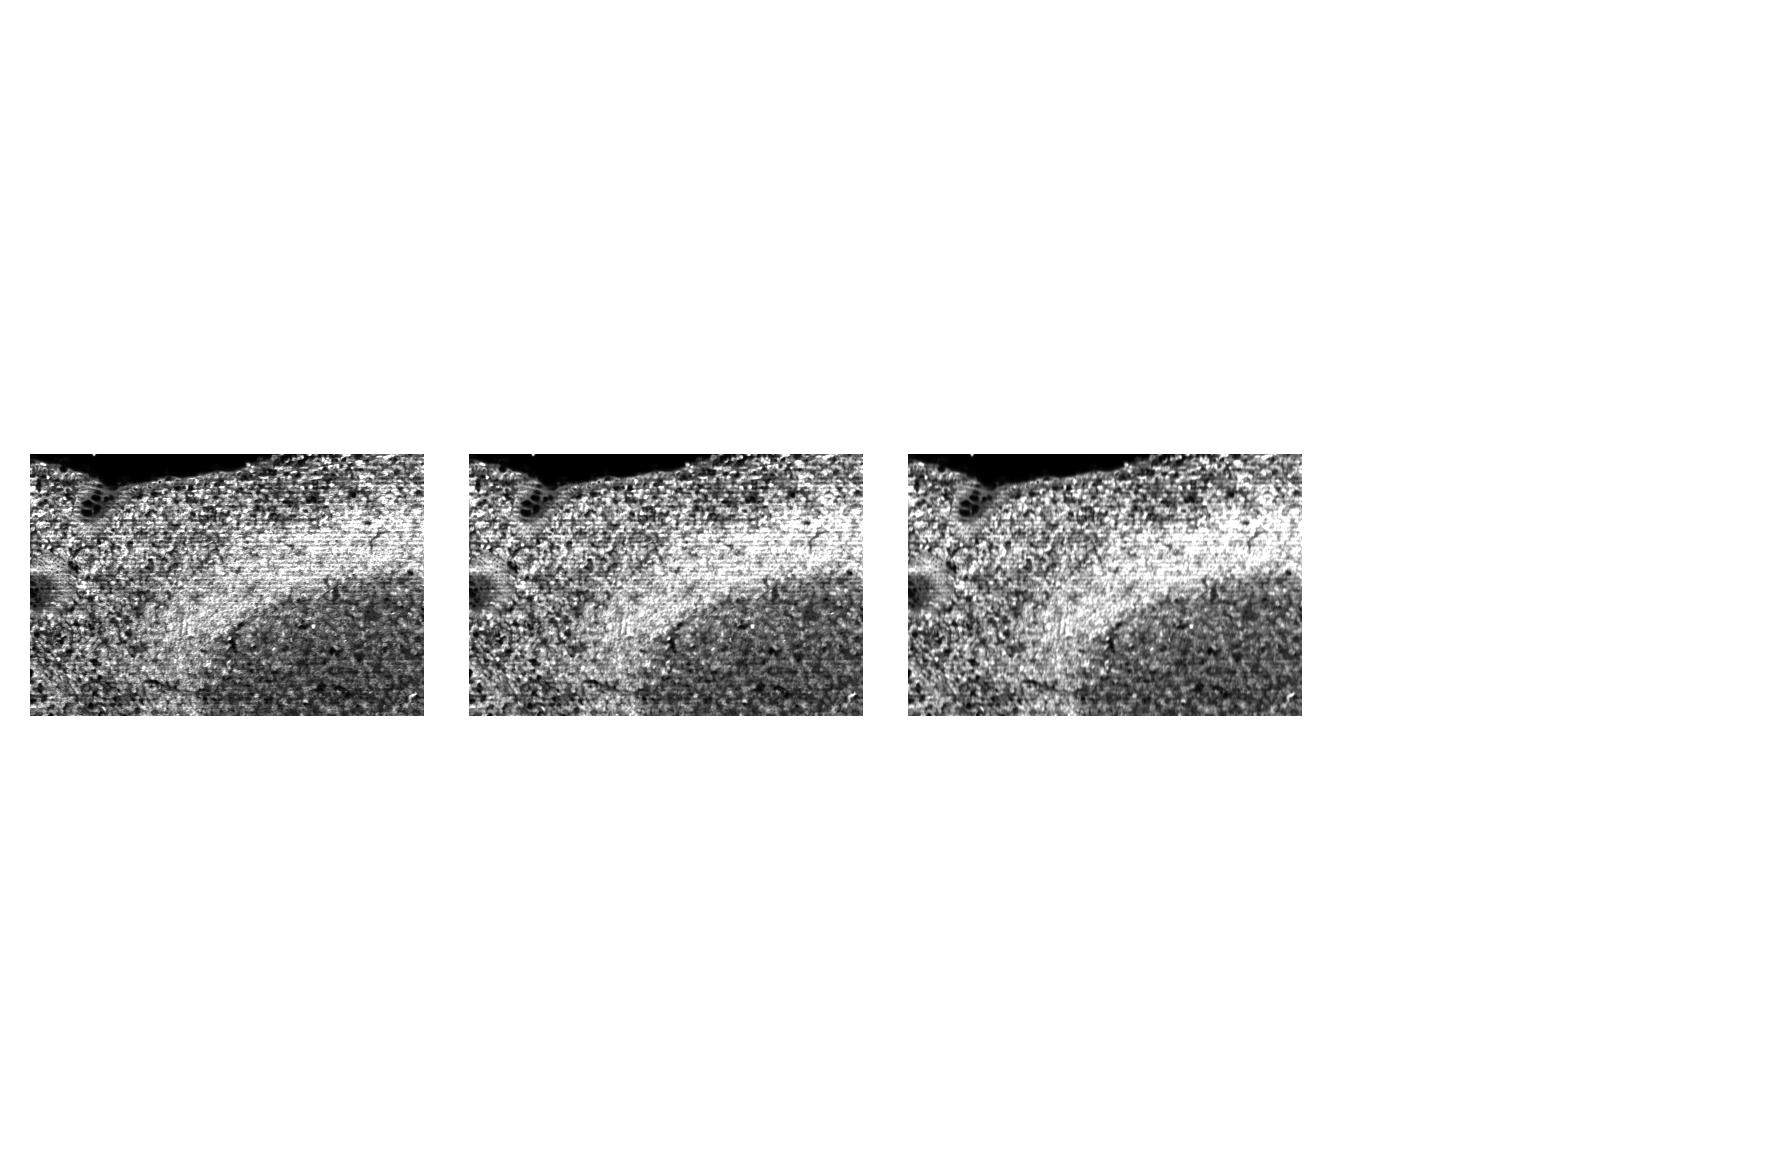

In [4]:
def remove_horizontal_artifacts_med(image):
    # Apply median filter along the y-axis
    filtered = ndimage.median_filter(image, size=(5, 2))
    
    # Subtract filtered image from original image
    result = filtered
#     result = np.abs(image - filtered)
#     result = filters.gaussian(result, sigma=0.8)
    return result

def remove_horizontal_artifacts_gauss(image):
    # Apply median filter along the y-axis
    filtered = ndimage.gaussian_filter(image, sigma=(2.5, 0.2))
    
    # Subtract filtered image from original image
    result = filtered
#     result = np.abs(image - filtered)
#     result = filters.gaussian(result, sigma=0.8)
    return result

def remove_horizontal_artifacts_fft(image):
    # Apply Fourier Transform Representation on the image
    fft = fftpack.fft2(image)

    # Remove horizontal artifacts and patterns
    fft[:, 100:-100] = 0

    # Inverse Fourier Transform to get the image back in spatial domain
    new_image = np.real(fftpack.ifft2(fft))

    return new_image

def remove_horizontal_artifacts_sobel(image):
    # Apply Gaussian filter to smooth the image and reduce noise
    blurred_image = filters.gaussian(image, sigma=2)

    # Apply Sobel filter to detect edges in the vertical direction
    sobel_x = filters.sobel(blurred_image)

    # Threshold the Sobel image to create a binary mask of vertical edges
    threshold = filters.threshold_otsu(np.abs(sobel_x))
    mask = np.abs(sobel_x) > threshold

    # Dilate the mask to fill gaps between edges and create a solid line for each horizontal artifact
    dilated_mask = morphology.binary_dilation(mask, selem=morphology.rectangle(1, 20))

    # Invert the mask so that the artifacts are black and the rest of the image is white
    inverted_mask = np.logical_not(dilated_mask)

    # Apply the inverted mask to the original image to remove the horizontal artifacts
    result = np.where(inverted_mask, image, 255)

    return result


def remove_horizontal_artifacts_fft(image):
    # Apply Fourier Transform Representation on the image
    fft = fftpack.fft2(image)

    # Remove horizontal artifacts and patterns
    fft[:, 100:-100] = 0

    # Inverse Fourier Transform to get the image back in spatial domain
    new_image = np.real(fftpack.ifft2(fft))

    return new_image

x = 360
y = 90

channels = ['Rh103', 'Lu175', 'Tb159', 'Pr141']
img = acq_xarray.sel(channel=channels[0]).values
img = transform.rescale(img, scale=(1, 1))
img = img[y:y+800, x:x+1200]

fig, axs = plt.subplots(ncols = 4, dpi=300)
vmin, vmax = np.percentile(img, [0, 95])
axs[0].imshow(img, vmin=vmin, vmax=vmax, cmap='gray')

img_filtered = remove_horizontal_artifacts_med(img)
vmin, vmax = np.percentile(img_filtered, [0, 95])
axs[1].imshow(img_filtered, vmin=vmin, vmax=vmax, cmap='gray')

img_filtered = remove_horizontal_artifacts_gauss(img)
vmin, vmax = np.percentile(img_filtered, [0, 95])
axs[2].imshow(img_filtered, vmin=vmin, vmax=vmax, cmap='gray')

for ax in axs.flatten():
    ax.axis('off')   
plt.tight_layout()
plt.show()


for channel in channels:
    img = acq_xarray.sel(channel=channel).values
    img = transform.rescale(img, scale=(1, 0.95))

    img = img[y:y+800, x:x+1200]
    
    savename = out_dir / f"{channel}.tif"
    tifffile.imwrite(savename, img)
    
    img_filtered = remove_horizontal_artifacts_gauss(img)
    savename = str(savename).replace(".tif", "_gauss_col_filtered.tif")
    tifffile.imwrite(savename, img_filtered)    
    
    img_fft = remove_horizontal_artifacts_fft(img)
    savename = str(savename).replace("_gauss_col_filtered.tif", "_fft_filtered.tif")
    tifffile.imwrite(savename, img_fft)    
    
    img_sbl = remove_horizontal_artifacts_sobel(img)
    savename = str(savename).replace("_fft_filtered.tif", "_sbl_filtered.tif")
    tifffile.imwrite(savename, img_sbl)   
    
    img_filtered = remove_horizontal_artifacts_med(img)
    savename = str(savename).replace("_sbl_filtered.tif", "_med_col_filtered.tif")
    tifffile.imwrite(savename, img_filtered)   

